In [96]:
import sqlite3
from typing import Annotated, Literal
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode
from langchain_community.utilities import SQLDatabase

In [97]:
connection= sqlite3.connect("mydb.db")

In [98]:
table_creation_query = """
CREATE TABLE IF NOT EXISTS employees (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    age INTEGER NOT NULL,
    department TEXT NOT NULL,
    salary REAL NOT NULL
);
"""

In [99]:
table_creation_query2 = """
CREATE TABLE IF NOT EXISTS customers (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    email TEXT NOT NULL,
    phone TEXT NOT NULL,
    address TEXT NOT NULL
);
"""

In [100]:
table_creation_query3="""
CREATE TABLE IF NOT EXISTS orders (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id INTEGER NOT NULL,
    order_date TEXT NOT NULL,
    total_amount REAL NOT NULL,
    FOREIGN KEY (customer_id) REFERENCES customers (id)
);
"""

In [101]:
cursor=connection.cursor()

In [102]:
cursor.execute(table_creation_query)

In [103]:
cursor.execute(table_creation_query2)
cursor.execute(table_creation_query3)

In [104]:
insert_query = """
INSERT INTO employees (name, age, department, salary)
VALUES (?, ?, ?, ?);
"""
insert_query2 = """
INSERT INTO customers (name, email, phone, address)
VALUES (?, ?, ?, ?);
"""
insert_query3 = """
INSERT INTO orders (customer_id, order_date, total_amount)
VALUES (?, ?, ?);
"""


In [105]:
employees_data = [
    ("John Doe", 30, "HR", 50000),
    ("Jane Smith", 28, "IT", 60000),
    ("Alice Johnson", 35, "Finance", 70000),
    ("Bob Brown", 40, "Marketing", 55000)
]

customers_data = [
    ("Charlie Black", "charlie@example.com", "555-1234", "123 Main St"),
    ("Diana White", "diana@example.com", "555-5678", "456 Oak Ave"),
    ("Edward Green", "edward@example.com", "555-9012", "789 Pine Rd"),
    ("Fiona Gray", "fiona@example.com", "555-3456", "101 Elm Blvd")
]

orders_data = [
    (1, "2023-05-15", 299.99),
    (2, "2023-05-16", 149.50),
    (3, "2023-05-17", 499.99),
    (4, "2023-05-18", 75.25)
]

# Insert data into tables
cursor.executemany(insert_query, employees_data)
cursor.executemany(insert_query2, customers_data)
cursor.executemany(insert_query3, orders_data)

# Commit the changes
connection.commit()

In [106]:
cursor.execute("select * from employees")
for row in cursor.fetchall():
    print(row)

(1, 'John Doe', 30, 'HR', 50000.0)
(2, 'Jane Smith', 28, 'IT', 60000.0)
(3, 'Alice Johnson', 35, 'Finance', 70000.0)
(4, 'Bob Brown', 40, 'Marketing', 55000.0)
(5, 'John Doe', 30, 'HR', 50000.0)
(6, 'Jane Smith', 28, 'IT', 60000.0)
(7, 'Alice Johnson', 35, 'Finance', 70000.0)
(8, 'Bob Brown', 40, 'Marketing', 55000.0)


In [107]:
from langchain_community.utilities import SQLDatabase

In [108]:
db=SQLDatabase.from_uri("sqlite:///mydb.db")

In [109]:
db.dialect

'sqlite'

In [110]:
db.get_usable_table_names()

['customers', 'employees', 'orders']

In [111]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

# Load environment variables from .env file
load_dotenv()

# Now the key is available to the Groq client
llm = ChatGroq(model="llama3-70b-8192")


In [112]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama3-70b-8192")

In [113]:
llm.invoke("Hello")

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.074285714, 'prompt_time': 0.004951703, 'queue_time': 0.054756455999999995, 'total_time': 0.079237417}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--7ff5a2b6-d4da-4e47-8ed6-4d50ad51d484-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})

In [114]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

In [115]:
toolkit=SQLDatabaseToolkit(db=db, llm=llm)


In [116]:
tools=toolkit.get_tools()
for tool in tools:
    print(tool.name)
    

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [117]:
list_tables_tool=next((tool for tool in tools if tool.name=="sql_db_list_tables"), None)


In [118]:
list_tables_tool

ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000014ACBFC27E0>)

In [119]:
get_schema_tool=next((tool for tool in tools if tool.name=="sql_db_schema"), None)

llm_to_get_schema=llm.bind_tools([get_schema_tool])


In [120]:
from langchain_core.tools import tool
@tool
def query_to_database(query:str) -> str:
    """
    This tool executes a SQL query and returns the result.
    """
    result=db.run_no_throw(query)
    if not result:
        return "error:query failed."
    return result

In [121]:
query_to_database.invoke("select* from employees;")

"[(1, 'John Doe', 30, 'HR', 50000.0), (2, 'Jane Smith', 28, 'IT', 60000.0), (3, 'Alice Johnson', 35, 'Finance', 70000.0), (4, 'Bob Brown', 40, 'Marketing', 55000.0), (5, 'John Doe', 30, 'HR', 50000.0), (6, 'Jane Smith', 28, 'IT', 60000.0), (7, 'Alice Johnson', 35, 'Finance', 70000.0), (8, 'Bob Brown', 40, 'Marketing', 55000.0)]"

In [122]:
llm_with_tools=llm.bind_tools([query_to_database])

In [123]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [124]:
def handle_tool_error(state:State):
    error = state.get("error") 
    tool_calls = state["messages"][-1].tool_calls
    return { "messages": [ ToolMessage(content=f"Error: {repr(error)}\n please fix your mistakes.",tool_call_id=tc["id"],) for tc in tool_calls ] }

def create_node_from_tool_with_fallback(tools:list)-> RunnableWithFallbacks[Any, dict]:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")

In [125]:
list_tables=create_node_from_tool_with_fallback([list_tables_tool])
get_schema=create_node_from_tool_with_fallback([get_schema_tool])
query_database=create_node_from_tool_with_fallback([query_to_database])

In [126]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert. Carefully review the SQL query for common mistakes, including:

Issues with NULL handling (e.g., NOT IN with NULLs)
Improper use of UNION instead of UNION ALL
Incorrect use of BETWEEN for exclusive ranges
Data type mismatches or incorrect casting
Quoting identifiers improperly
Incorrect number of arguments in functions
Errors in JOIN conditions

If you find any mistakes, rewrite the query to fix them. If it's correct, reproduce it as is."""

query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system), ("placeholder", "{messages}")])

check_generated_query = query_check_prompt | llm_with_tools

In [127]:
check_generated_query.invoke({"messages": [("user", "SELECT * FROM Employees LIMIT 5;")]})


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3pbj', 'function': {'arguments': '{"query":"SELECT * FROM Employees LIMIT 5;"}', 'name': 'query_to_database'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 1010, 'total_tokens': 1083, 'completion_time': 0.208571429, 'prompt_time': 0.040323487, 'queue_time': 0.058745032999999995, 'total_time': 0.248894916}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2a4097d2-20d3-49dc-b1ca-614f3b0e366c-0', tool_calls=[{'name': 'query_to_database', 'args': {'query': 'SELECT * FROM Employees LIMIT 5;'}, 'id': 'call_3pbj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1010, 'output_tokens': 73, 'total_tokens': 1083})

In [128]:
check_generated_query.invoke({"messages": [("user", "SELECT +++ FROM Employees LIMITs 5;")]})


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w0rn', 'function': {'arguments': '{"query":"SELECT * FROM Employees LIMIT 5;"}', 'name': 'query_to_database'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 219, 'prompt_tokens': 1011, 'total_tokens': 1230, 'completion_time': 0.696886763, 'prompt_time': 0.039772942, 'queue_time': 0.054629417000000006, 'total_time': 0.736659705}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--538ffd56-749c-4368-bd92-c0ffc996b0c2-0', tool_calls=[{'name': 'query_to_database', 'args': {'query': 'SELECT * FROM Employees LIMIT 5;'}, 'id': 'call_w0rn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1011, 'output_tokens': 219, 'total_tokens': 1230})

In [129]:
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")
    
llm_with_final_answer=llm.bind_tools([SubmitFinalAnswer])

In [130]:
# Add a node for a model to generate a query based on the question and schema
query_gen_system_prompt = """You are a SQL expert with a strong attention to detail.Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

1. DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

2. Output the SQL query that answers the input question without a tool call.

3. Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.

4. You can order the results by a relevant column to return the most interesting examples in the database.

5. Never query for all the columns from a specific table, only ask for the relevant columns given the question.

6. If you get an error while executing a query, rewrite the query and try again.

7. If you get an empty result set, you should try to rewrite the query to get a non-empty result set.

8. NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

9. If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

10. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer. """

query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system_prompt), ("placeholder", "{messages}")])

query_generator = query_gen_prompt | llm_with_final_answer

In [131]:
query_generator.invoke({"messages": [("can you fetch the data from employee table?")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rxz3', 'function': {'arguments': '{"final_answer":"The results of the query are: [insert results here]."}', 'name': 'SubmitFinalAnswer'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 114, 'prompt_tokens': 1210, 'total_tokens': 1324, 'completion_time': 0.48334355, 'prompt_time': 0.038473015, 'queue_time': 0.061170034, 'total_time': 0.521816565}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a413be51-e49e-471f-9bfb-49edf1ca84bb-0', tool_calls=[{'name': 'SubmitFinalAnswer', 'args': {'final_answer': 'The results of the query are: [insert results here].'}, 'id': 'call_rxz3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1210, 'output_tokens': 114, 'total_tokens': 1324})

In [132]:
def first_tool_call(state:State)->dict[str,list[AIMessage]]:
    print(f"state from first_tool_call: {state}")
    return{"messages": [AIMessage(content="",tool_calls=[{"name":"sql_db_list_tables","args":{},"id":"tool_abcd123"}])]}

In [133]:
def check_the_given_query(state:State):
    print(f"state from check the given query: {state}")
    return {"messages": [check_generated_query.invoke({"messages": [state["messages"][-1]]})]}

In [134]:
def generation_query(state:State):
    message = query_generator.invoke(state)
    print(f"state from generation_query: {state}")

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}

In [135]:
def should_continue(state:State):
    print(f"state from should_continue: {state}")
    messages = state["messages"]
    last_message = messages[-1]
    print("last message")
    print(last_message)
    if getattr(last_message, "tool_calls", None):
        print("sooo")
        return END
    elif last_message.content.startswith("Error:"):
        print("dooo")
        return "query_gen"
    else:
        print("oooo")
        return "correct_query"

In [136]:

def llm_get_schema(state:State):
    print("state from llm_get_schema", state)
    response = llm_to_get_schema.invoke(state["messages"])
    return {"messages": [response]}

In [137]:

workflow = StateGraph(State)
workflow.add_node("first_tool_call",first_tool_call)
workflow.add_node("list_tables_tool", list_tables)
workflow.add_node("get_schema_tool", get_schema)
workflow.add_node("model_get_schema", llm_get_schema)
workflow.add_node("query_gen", generation_query)
workflow.add_node("correct_query", check_the_given_query)
workflow.add_node("execute_query", query_database)

In [138]:
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges("query_gen",should_continue,
                            {END:END,
                            "correct_query":"correct_query"})
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

In [139]:

app=workflow.compile()

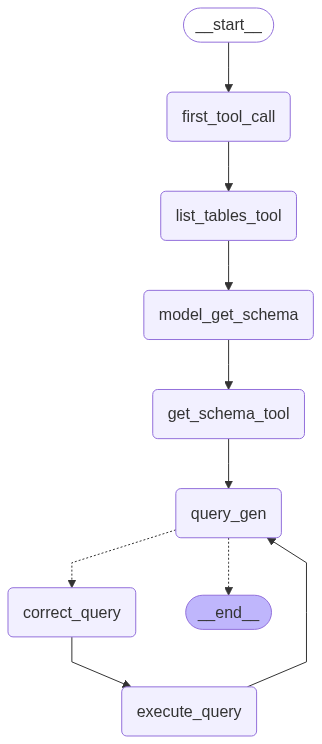

In [140]:

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [165]:

query={"messages": [("user", "how many order are there which is more than 1000 rupees in order table?")]}

In [166]:

response=app.invoke(query)

state from first_tool_call: {'messages': [HumanMessage(content='how many order are there which is more than 1000 rupees in order table?', additional_kwargs={}, response_metadata={}, id='29b2efc9-b71e-42c4-8540-f05aedf682fa')]}
state from llm_get_schema {'messages': [HumanMessage(content='how many order are there which is more than 1000 rupees in order table?', additional_kwargs={}, response_metadata={}, id='29b2efc9-b71e-42c4-8540-f05aedf682fa'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='741fb298-db54-48f2-8226-26c33d633962', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]), ToolMessage(content='customers, employees, orders', name='sql_db_list_tables', id='eb2479bd-52da-4a31-befc-4a17cd7e544d', tool_call_id='tool_abcd123')]}
state from generation_query: {'messages': [HumanMessage(content='how many order are there which is more than 1000 rupees in order table?', additional_kwargs={}, response_metadata={}, id=

In [167]:

response["messages"][-1].tool_calls[0]["args"]["final_answer"]

''

In [144]:
def print_all_tables_data():
    tables = db.get_usable_table_names()
    
    for table in tables:
        print(f"\n--- Table: {table} ---")
        
        # Get schema information
        schema_result = db.run_no_throw(f"PRAGMA table_info({table});")
        print(f"Schema:\n{schema_result}\n")
        
        # Get all rows from the table
        rows_result = db.run_no_throw(f"SELECT * FROM {table} LIMIT 10;")
        print(f"Data:\n{rows_result}\n")
        
        print("-" * 50)

# Execute the function
print_all_tables_data()


--- Table: customers ---
Schema:
[(0, 'id', 'INTEGER', 0, None, 1), (1, 'name', 'TEXT', 1, None, 0), (2, 'email', 'TEXT', 1, None, 0), (3, 'phone', 'TEXT', 1, None, 0), (4, 'address', 'TEXT', 1, None, 0)]

Data:
[(1, 'Charlie Black', 'charlie@example.com', '555-1234', '123 Main St'), (2, 'Diana White', 'diana@example.com', '555-5678', '456 Oak Ave'), (3, 'Edward Green', 'edward@example.com', '555-9012', '789 Pine Rd'), (4, 'Fiona Gray', 'fiona@example.com', '555-3456', '101 Elm Blvd'), (5, 'Charlie Black', 'charlie@example.com', '555-1234', '123 Main St'), (6, 'Diana White', 'diana@example.com', '555-5678', '456 Oak Ave'), (7, 'Edward Green', 'edward@example.com', '555-9012', '789 Pine Rd'), (8, 'Fiona Gray', 'fiona@example.com', '555-3456', '101 Elm Blvd')]

--------------------------------------------------

--- Table: employees ---
Schema:
[(0, 'id', 'INTEGER', 0, None, 1), (1, 'name', 'TEXT', 1, None, 0), (2, 'age', 'INTEGER', 1, None, 0), (3, 'department', 'TEXT', 1, None, 0), (4